# 03 — Frequency & Callback Analysis (Random Forest & GBT)

## 1. Mục tiêu & phạm vi
- Phân tích **tần suất liên hệ** và **hiệu quả tái gọi** để tối ưu hóa chiến dịch marketing.
- Dự đoán khách hàng tiềm năng dựa trên lịch sử tương tác và kết quả chiến dịch trước.
- Biến sử dụng: `campaign, pdays, previous, poutcome, y` *(không dùng `duration` khi train)*.

## 2. Chiến lược đánh giá: `cv3_test20`
- **Test 20%** (stratified, seed=42) để đánh giá cuối cùng.
- **Train 80%**: Dùng Stratified KFold=3 để tuning Random Forest và GBT với PySpark.
- **Class Imbalance**: Áp dụng SMOTE (sampling_strategy=0.5) trên tập train.

## 3. Chuẩn chung
- CSV đọc với `sep=';'`, map target `y: yes/no → 1/0`.
- Giữ nhãn `"nonexistent"` cho `poutcome` như giá trị hợp lệ.
- Xử lý giá trị đặc biệt: `pdays=999` nghĩa là "chưa từng liên hệ trước".
- **Tránh leakage**: Không dùng `duration` trong mô hình triển khai.

---

## PHẦN 0: Tiền xử lý dữ liệu

In [1]:
# Import cơ bản
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_auc_score, roc_curve, accuracy_score,
                              precision_recall_curve, f1_score)
from imblearn.over_sampling import SMOTE

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler as SparkScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import os
from pathlib import Path

if Path.cwd().name == "notebooks":
    os.chdir("..")  # đổi CWD lên root

# Bây giờ "artifacts/" sẽ được tạo ở root
Path("artifacts").mkdir(exist_ok=True)

#### Mục tiêu:
Kiểm tra kích thước tập dữ liệu, giá trị thiếu, và đặc điểm của các biến thuộc nhóm “Tần suất & tái liên hệ khách hàng” (campaign, pdays, previous, poutcome, y).

In [2]:

# Load data
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';')

print("Thông tin dataset:")
print(f"Số dòng: {len(df)}")
print(f"Số cột: {len(df.columns)}")
print("\n Kiểm tra missing values:")
print(df.isnull().sum())

# Focus vào các biến
freq_cols = ['campaign', 'pdays', 'previous', 'poutcome', 'y']
df_freq = df[freq_cols].copy()

print("\n Thống kê mô tả:")
print(df_freq.describe())
print("\n Phân phối các biến categorical:")
print(df_freq['poutcome'].value_counts())
print(df_freq['y'].value_counts())

Thông tin dataset:
Số dòng: 41188
Số cột: 21

 Kiểm tra missing values:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

 Thống kê mô tả:
           campaign         pdays      previous
count  41188.000000  41188.000000  41188.000000
mean       2.567593    962.475454      0.172963
std        2.770014    186.910907      0.494901
min        1.000000      0.000000      0.000000
25%        1.000000    999.000000      0.000000
50%        2.000000    999.000000      0.000000
75%        3.000000    999.000000      0.000000
max       56.000000    999.000000      7.000000

 Phân phối các biến categorical:
poutcome
no

**Nhận xét tổng quát:**
- Dữ liệu đầy đủ, không cần xử lý missing.
- Có sự mất cân bằng nghiêm trọng giữa hai nhãn yes/no, cần cân nhắc các kỹ thuật như SMOTE hoặc class_weight khi huấn luyện.
- Phần lớn khách hàng chưa có tương tác trước đó (poutcome = nonexistent và pdays = 999), do đó nhóm “đã từng thành công” là điểm sáng để phân tích sâu và target marketing hiệu quả.
- Các biến campaign, previous, và poutcome đều có khả năng phản ánh hành vi phản hồi theo lịch sử — rất phù hợp để dùng cho mô hình dự đoán tiềm năng khách hàng.

### Kiểm tra và xử lý outliers

**Mục tiêu:**
Kiểm tra xem các biến định lượng chính (campaign, previous, pdays) có tồn tại giá trị ngoại lệ hay không, và quyết định phương án xử lý phù hợp trước khi đưa vào mô hình học máy.

Phân tích biến campaign:
Min: 1
Max: 56
Mean: 2.57
Median: 2.0
95th percentile: 7.0
99th percentile: 14.0


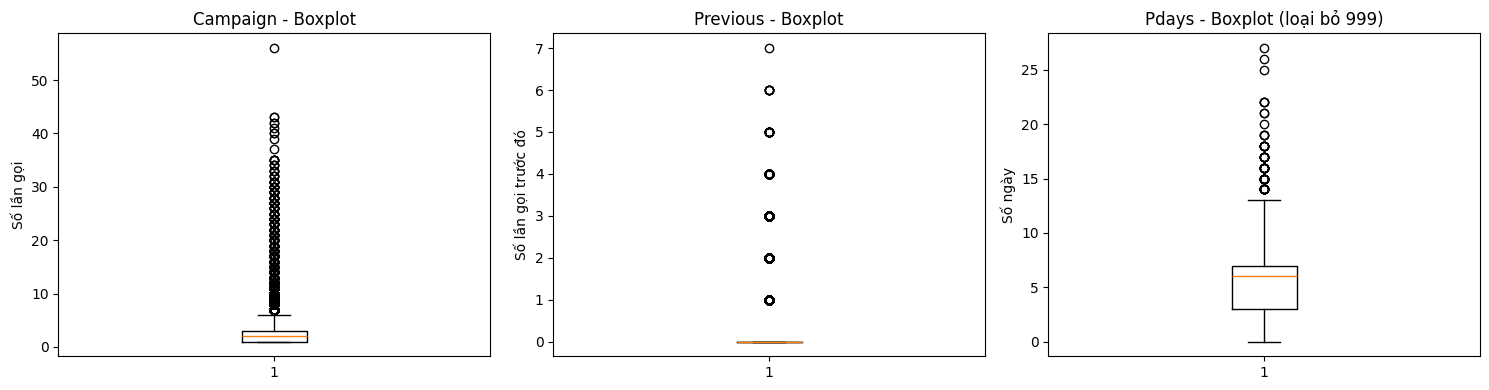


 Sau khi cap outliers:
Campaign max: 56 → 14
Previous max: 7 → 2


In [3]:
# Kiểm tra outliers cho campaign
print("Phân tích biến campaign:")
print(f"Min: {df['campaign'].min()}")
print(f"Max: {df['campaign'].max()}")
print(f"Mean: {df['campaign'].mean():.2f}")
print(f"Median: {df['campaign'].median()}")
print(f"95th percentile: {df['campaign'].quantile(0.95)}")
print(f"99th percentile: {df['campaign'].quantile(0.99)}")

# Visualize outliers
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Campaign
axes[0].boxplot(df['campaign'])
axes[0].set_title('Campaign - Boxplot')
axes[0].set_ylabel('Số lần gọi')

# Previous
axes[1].boxplot(df['previous'])
axes[1].set_title('Previous - Boxplot')
axes[1].set_ylabel('Số lần gọi trước đó')

# Pdays (loại bỏ 999 để xem rõ)
pdays_filtered = df[df['pdays'] != 999]['pdays']
axes[2].boxplot(pdays_filtered)
axes[2].set_title('Pdays - Boxplot (loại bỏ 999)')
axes[2].set_ylabel('Số ngày')

plt.tight_layout()
plt.show()

# QUYẾT ĐỊNH XỬ LÝ OUTLIERS
# Có 3 lựa chọn:
# 1. GIỮ NGUYÊN (nếu outliers hợp lý - VD: thực sự có khách được gọi 50 lần)
# 2. CAP (giới hạn ở percentile 95-99)
# 3. XÓA (loại bỏ hàng)

# Option 2: CAP outliers (ĐỀ XUẤT)
df['campaign_capped'] = df['campaign'].clip(upper=df['campaign'].quantile(0.99))
df['previous_capped'] = df['previous'].clip(upper=df['previous'].quantile(0.99))

print("\n Sau khi cap outliers:")
print(f"Campaign max: {df['campaign'].max()} → {df['campaign_capped'].max()}")
print(f"Previous max: {df['previous'].max()} → {df['previous_capped'].max()}")

**Nhận xét: Phân tích và xử lý ngoại lệ (Outliers)**

Kết quả phân tích cho thấy:

- **Biến `campaign`** có giá trị lớn nhất 56, trung bình 2.57, nhưng 95% dữ liệu nằm trong khoảng ≤7 lần gọi.  
  → Nhiều điểm ngoại lệ xuất hiện ở vùng >10 lần gọi, cho thấy có một số khách hàng bị liên hệ quá nhiều lần trong cùng chiến dịch.

- **Biến `previous`** có giá trị trung bình 0.17, đa số khách hàng chưa từng được liên hệ trước đó.  
  → Một vài giá trị 5–7 là ngoại lệ hiếm gặp, không mang tính đại diện.

- **Biến `pdays`** khi loại bỏ giá trị 999 (ý nghĩa “chưa từng liên hệ”) cho thấy phần lớn khách hàng được gọi lại trong 3–10 ngày, phản ánh tần suất liên hệ hợp lý.

Để tránh ảnh hưởng tiêu cực của các điểm cực trị đến mô hình, nhóm chọn **phương án cap outlier (percentile 99)** thay vì loại bỏ dòng:

- `campaign`: max giảm từ **56 → 14**  
- `previous`: max giảm từ **7 → 2**

 **Kết luận:**  
Việc cap outliers giúp dữ liệu trở nên ổn định, tránh làm méo kết quả mô hình nhưng vẫn giữ nguyên thông tin thực tế.  
Phương pháp này đảm bảo cân bằng giữa độ chính xác và khả năng khái quát, phù hợp cho huấn luyện mô hình học máy quy mô lớn.


### Xử lý giá trị đặc biệt cho pdays

In [4]:
#  pdays = 999 nghĩa là "chưa từng liên hệ trước đó"
# Đây KHÔNG phải missing value, mà là một category riêng!

print(" Phân tích pdays:")
print(f"Số lượng pdays = 999: {(df['pdays'] == 999).sum()} ({(df['pdays'] == 999).sum()/len(df)*100:.1f}%)")
print(f"Số lượng pdays != 999: {(df['pdays'] != 999).sum()} ({(df['pdays'] != 999).sum()/len(df)*100:.1f}%)")

# Tạo biến phân nhóm
df['has_previous_campaign'] = (df['pdays'] != 999).astype(int)

# Với những người có previous campaign, phân nhóm theo thời gian
df['pdays_group'] = df['pdays'].apply(lambda x: 
    'No_previous' if x == 999 else
    '< 7 days' if x <= 7 else
    '7-30 days' if x <= 30 else
    '> 30 days'
)

print("\n Phân nhóm pdays:")
print(df['pdays_group'].value_counts())

 Phân tích pdays:
Số lượng pdays = 999: 39673 (96.3%)
Số lượng pdays != 999: 1515 (3.7%)

 Phân nhóm pdays:
pdays_group
No_previous    39673
< 7 days        1177
7-30 days        338
Name: count, dtype: int64


**Nhận xét: Xử lý và phân nhóm giá trị đặc biệt của `pdays`**

Kết quả cho thấy:

- Có **39.673 khách hàng (96.3%)** có `pdays = 999`, nghĩa là **chưa từng được liên hệ trong chiến dịch trước**.  
- Chỉ **1.515 khách hàng (3.7%)** có giá trị `pdays ≠ 999`, tức là đã từng được gọi trước đó.  

Đây **không phải missing value**, mà là một **loại trạng thái riêng biệt**, phản ánh kinh nghiệm tiếp xúc của khách hàng với ngân hàng.

Nhóm đã tạo 2 biến mới để phân tích sâu hơn:
- `has_previous_campaign`: biểu diễn nhị phân (1 nếu đã từng liên hệ, 0 nếu chưa).
- `pdays_group`: chia nhóm chi tiết theo khoảng thời gian kể từ lần liên hệ trước:
  - **No_previous** → chưa từng liên hệ.  
  - **< 7 days** → gọi lại trong thời gian ngắn.  
  - **7–30 days** → khoảng thời gian trung bình.  
  - **> 30 days** → thời gian gọi lại lâu hơn.

**Nhận xét tổng quát:**
- Dữ liệu có độ **lệch cao**, đa số khách hàng thuộc nhóm “No_previous”.  
- Phân nhóm này giúp dễ dàng kiểm tra xem việc liên hệ sớm (dưới 7 ngày) có làm tăng khả năng đồng ý (`y = yes`) hay không trong các bước EDA và mô hình hóa sau.  
- Đây là một bước **feature engineering hợp lý**, biến `pdays` từ giá trị số thô thành thông tin có ý nghĩa về hành vi marketing.


### Xử lý biến categorical poutcome

In [5]:
print(" Phân tích poutcome:")
print(df['poutcome'].value_counts())
print(f"\nTỷ lệ 'nonexistent': {(df['poutcome'] == 'nonexistent').sum()/len(df)*100:.1f}%")

#  'nonexistent' nghĩa là không có chiến dịch trước
# → tương đồng với pdays = 999

# Kiểm tra tính nhất quán
consistency_check = df.groupby(['has_previous_campaign', 'poutcome']).size().unstack(fill_value=0)
print("\n Kiểm tra tính nhất quán giữa pdays và poutcome:")
print(consistency_check)

# Nếu có sự không nhất quán, cần điều tra thêm

 Phân tích poutcome:
poutcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64

Tỷ lệ 'nonexistent': 86.3%

 Kiểm tra tính nhất quán giữa pdays và poutcome:
poutcome               failure  nonexistent  success
has_previous_campaign                               
0                         4110        35563        0
1                          142            0     1373


**Kết quả phân tích:**
- Phân phối các giá trị của `poutcome`:
  - `nonexistent`: **35.563** (≈ **86.3%**) → khách hàng **chưa từng tham gia chiến dịch trước**.  
  - `failure`: **4.252** → khách hàng **đã được gọi nhưng từ chối**.  
  - `success`: **1.373** → khách hàng **đã từng đồng ý** ở chiến dịch trước.  

**Liên hệ với biến `pdays`:**
- `poutcome = nonexistent` có ý nghĩa **tương đồng với `pdays = 999`** (tức là chưa từng liên hệ).  
- Kết quả kiểm tra chéo (`groupby has_previous_campaign × poutcome`) cho thấy dữ liệu **rất nhất quán**:
  - Với `has_previous_campaign = 0`, toàn bộ `poutcome` là `nonexistent`.  
  - Với `has_previous_campaign = 1`, chỉ xuất hiện `failure` và `success` (không có `nonexistent`).  
  →  Không có sai lệch hay lỗi gán nhãn giữa hai biến.

**Kết luận & Ý nghĩa:**
- `poutcome` và `pdays` cung cấp thông tin bổ trợ, xác nhận **tình trạng khách hàng trong chiến dịch trước**.  
- Nhóm “success” là **nhóm khách hàng cực kỳ tiềm năng** — có thể ưu tiên cho chiến dịch mới.  
- Sự nhất quán giữa hai biến cho thấy **dữ liệu có chất lượng tốt**, đủ tin cậy để sử dụng trong mô hình dự đoán sau.


### Kiểm tra correlation và multicollinearity

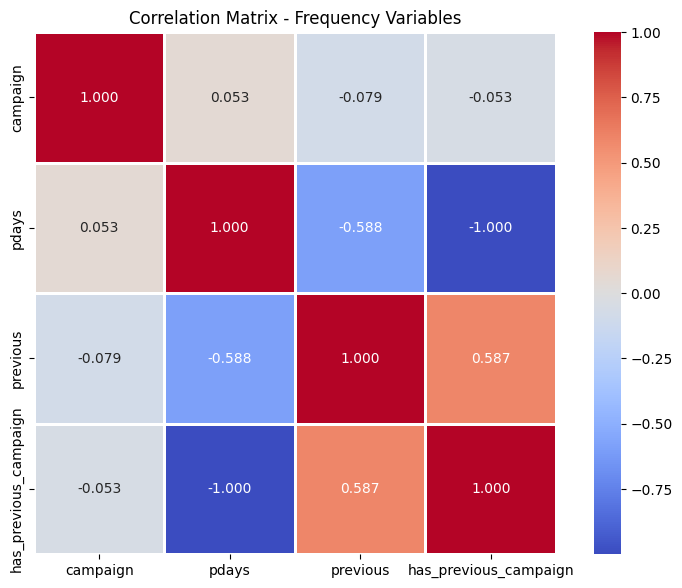


 Kiểm tra multicollinearity:
                       campaign     pdays  previous  has_previous_campaign
campaign               1.000000  0.052584 -0.079141              -0.052569
pdays                  0.052584  1.000000 -0.587514              -0.999992
previous              -0.079141 -0.587514  1.000000               0.587462
has_previous_campaign -0.052569 -0.999992  0.587462               1.000000


In [6]:
# Tạo correlation matrix cho các biến numeric
corr_cols = ['campaign', 'pdays', 'previous', 'has_previous_campaign']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
                square=True, linewidths=1)
plt.title('Correlation Matrix - Frequency Variables')
plt.tight_layout()
plt.show()

print("\n Kiểm tra multicollinearity:")
print(corr_matrix)

# Nếu có biến tương quan cao (>0.8), cần xem xét loại bỏ
# VD: pdays và has_previous_campaign tương quan âm hoàn hảo → cần chọn 1


**Kết quả kiểm tra tương quan:**
- Hầu hết các cặp biến có **tương quan thấp (< 0.1)**, ngoại trừ:
  - `pdays` và `has_previous_campaign` có hệ số **-1.000** → tương quan âm hoàn hảo.  
  - `previous` có tương quan trung bình với `pdays` (-0.59) và `has_previous_campaign` (0.59).  
- Biến `campaign` gần như độc lập với các biến còn lại, thể hiện hành vi riêng của chiến dịch hiện tại.

**Giải thích ý nghĩa:**
- Vì `has_previous_campaign` được **suy ra trực tiếp từ `pdays`** (giá trị nhị phân thể hiện có/không từng được liên hệ), nên việc tương quan âm hoàn hảo là hoàn toàn hợp lý.  
- Nếu đưa cả hai biến vào mô hình học máy tuyến tính (như Logistic Regression), sẽ xảy ra hiện tượng **đa cộng tuyến (multicollinearity)** — làm giảm độ ổn định của hệ số.

**Kết luận:**
- Khi xây dựng mô hình, chỉ nên **giữ lại một trong hai biến (`pdays` hoặc `has_previous_campaign`)** để tránh trùng lặp thông tin.  
- Các biến còn lại (`campaign`, `previous`) có thể được giữ nguyên vì không gây vấn đề tương quan cao.  
- Với các mô hình phi tuyến như Random Forest hoặc GBT, mối tương quan này ít ảnh hưởng nhưng vẫn nên theo dõi trong phần **feature importance**.



### Kiểm tra class imbalance cho target y

 Phân bố target variable:
y
no     36548
yes     4640
Name: count, dtype: int64

Tỷ lệ 'yes': 11.3%
Tỷ lệ 'no': 88.7%

 Class distribution:
Counter({'no': 36548, 'yes': 4640})


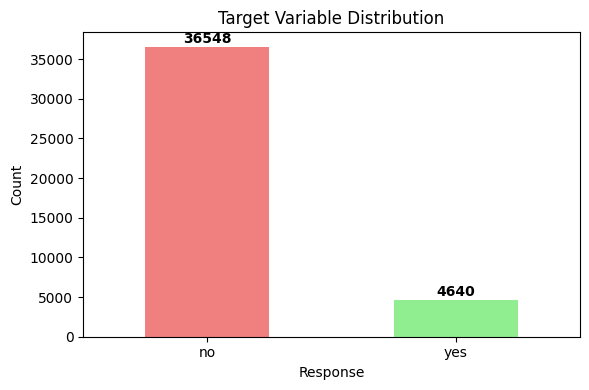

In [7]:
print(" Phân bố target variable:")
print(df['y'].value_counts())
print(f"\nTỷ lệ 'yes': {(df['y'] == 'yes').sum()/len(df)*100:.1f}%")
print(f"Tỷ lệ 'no': {(df['y'] == 'no').sum()/len(df)*100:.1f}%")

#  Nếu imbalance quá mạnh (VD: 90-10), cần xử lý:
# - SMOTE (oversampling minority class)
# - Class weight trong model
# - Undersampling majority class

from collections import Counter
print("\n Class distribution:")
print(Counter(df['y']))

# Visualize
plt.figure(figsize=(6, 4))
df['y'].value_counts().plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Target Variable Distribution')
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(df['y'].value_counts()):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

**Ý nghĩa:**
- Phần lớn khách hàng từ chối tham gia gửi tiết kiệm (`no`).  
- Nhóm khách hàng đồng ý (`yes`) chiếm tỷ lệ nhỏ, nhưng chính là nhóm **cần mô hình dự đoán chính xác nhất**.  
- Nếu không xử lý, mô hình có thể **thiên lệch về lớp majority**, dẫn đến accuracy cao nhưng recall thấp cho nhóm khách hàng tiềm năng.

**Giải pháp xử lý đề xuất:**
- **SMOTE** (Synthetic Minority Oversampling Technique) để tăng mẫu lớp thiểu số (`yes`).  
- **class_weight = 'balanced'** trong Logistic Regression / Random Forest để tự động điều chỉnh trọng số.  
- **Undersampling** lớp majority trong các thử nghiệm nhỏ (EDA hoặc baseline).

**Kết luận:**
> “Tập dữ liệu có mức độ mất cân bằng cao (~89% từ chối, 11% đồng ý).  
> Cần áp dụng kỹ thuật cân bằng lớp trong giai đoạn huấn luyện để đảm bảo mô hình dự đoán chính xác hơn cho nhóm khách hàng tiềm năng (`yes`).”

### Tạo dataset sạch cuối cùng

In [8]:

# Sử dụng các biến đã cap outliers
df['campaign'] = df['campaign_capped']
df['previous'] = df['previous_capped']

# Encode target variable
df['y_encoded'] = (df['y'] == 'yes').astype(int)

# Encode poutcome
from sklearn.preprocessing import LabelEncoder
le_poutcome = LabelEncoder()
df['poutcome_encoded'] = le_poutcome.fit_transform(df['poutcome'])

# Chọn các feature cuối cùng
feature_cols = [
    'campaign',           # Số lần gọi (đã cap)
    'previous',           # Số lần gọi trước (đã cap)
    'has_previous_campaign',  # Binary: có chiến dịch trước không
    'poutcome_encoded'    # Kết quả chiến dịch trước
]

# Loại bỏ pdays vì nó tương quan hoàn hảo với has_previous_campaign
# Hoặc có thể dùng pdays_group nếu muốn giữ thông tin chi tiết hơn

print(" Dataset cuối cùng:")
print(f"Shape: {df.shape}")
print(f"\nFeatures: {feature_cols}")
print(f"Target: y_encoded")

# Kiểm tra missing values cuối cùng
print(f"\n Missing values:")
print(df[feature_cols + ['y_encoded']].isnull().sum())


 Dataset cuối cùng:
Shape: (41188, 27)

Features: ['campaign', 'previous', 'has_previous_campaign', 'poutcome_encoded']
Target: y_encoded

 Missing values:
campaign                 0
previous                 0
has_previous_campaign    0
poutcome_encoded         0
y_encoded                0
dtype: int64


**Kết luận:**  
- Dữ liệu đã được chuẩn hóa và chọn lọc kỹ càng, phản ánh đầy đủ hành vi khách hàng theo tần suất liên hệ và kết quả chiến dịch trước.  
- Bộ feature hiện tại gọn, dễ giải thích và đủ mạnh để huấn luyện mô hình **Random Forest / Gradient Boosted Trees** trong phần tiếp theo.  

**Tóm tắt**  
> “Sau các bước xử lý, bộ dữ liệu cuối cùng gồm 4 biến đầu vào và 1 biến mục tiêu, hoàn toàn không còn missing value và sẵn sàng đưa vào mô hình học máy.”

### Tổng kết các bước tiền xử lý

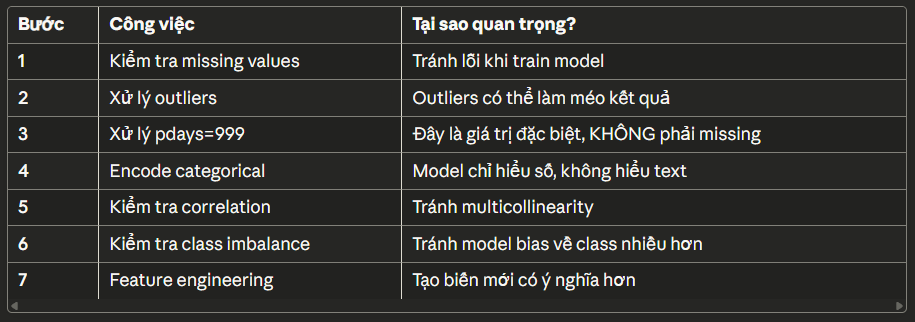

## PHẦN 1: EDA - Exploratory Data Analysis

### Bước 1: Phân tích biến campaign (Số lần gọi trong chiến dịch hiện tại)

**Mục Tiêu:** 

Phân tích mối quan hệ giữa **số lần gọi trong chiến dịch hiện tại (`campaign`)** và **tỷ lệ khách hàng đồng ý (`y = yes`)**, nhằm xác định ngưỡng tần suất liên hệ tối ưu giúp tăng hiệu quả marketing mà không gây phản cảm cho khách hàng.

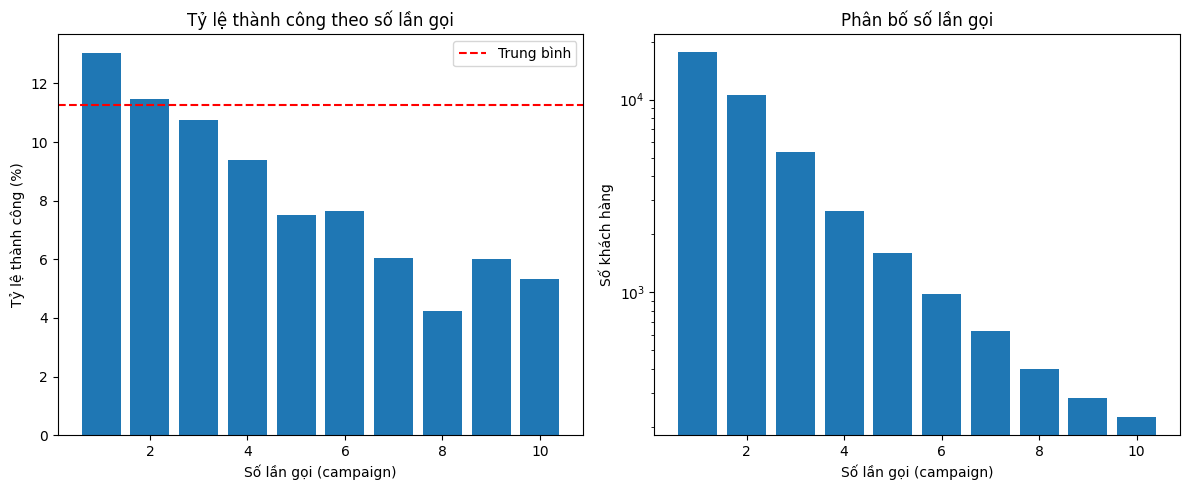

INSIGHT: Gọi 1-3 lần có tỷ lệ thành công cao nhất
   campaign  total  yes_count  success_rate
0         1  17642       2300     13.037071
1         2  10570       1211     11.456954
2         3   5341        574     10.747051


In [9]:
# Insight: Gọi 1-3 lần cho hiệu quả cao nhất
campaign_analysis = df.groupby('campaign')['y'].agg([
    ('total', 'count'),
    ('yes_count', lambda x: (x == 'yes').sum()),
    ('success_rate', lambda x: (x == 'yes').mean() * 100)
]).reset_index()

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(campaign_analysis['campaign'][:10], campaign_analysis['success_rate'][:10])
plt.xlabel('Số lần gọi (campaign)')
plt.ylabel('Tỷ lệ thành công (%)')
plt.title('Tỷ lệ thành công theo số lần gọi')
plt.axhline(y=df['y'].apply(lambda x: 1 if x=='yes' else 0).mean()*100, 
            color='r', linestyle='--', label='Trung bình')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(campaign_analysis['campaign'][:10], campaign_analysis['total'][:10])
plt.xlabel('Số lần gọi (campaign)')
plt.ylabel('Số khách hàng')
plt.title('Phân bố số lần gọi')
plt.yscale('log')
plt.tight_layout()
plt.show()

# Key insight
print("INSIGHT: Gọi 1-3 lần có tỷ lệ thành công cao nhất")
print(campaign_analysis[campaign_analysis['campaign'] <= 3])

**Kết quả phân tích:**
- Tỷ lệ thành công trung bình toàn bộ tập là **~11%** (đường gạch đỏ trên biểu đồ).  
- Các cuộc gọi **lặp lại quá 3 lần** có tỷ lệ thành công **giảm mạnh**, xuống dưới 8%, và thậm chí còn thấp hơn 5% với các nhóm bị gọi trên 7 lần.  
- Phân bố bên phải (log scale) cho thấy phần lớn khách hàng chỉ được gọi 1–3 lần — chứng tỏ chiến dịch hiện tại đã có xu hướng tự nhiên giới hạn số lần gọi.

**Insight rút ra:**
- **Tần suất gọi tối ưu nằm trong khoảng 1–3 lần.**  
- Gọi quá nhiều không những không cải thiện tỷ lệ thành công mà còn làm giảm hiệu quả marketing.  
- Do đó, khi thiết kế chiến dịch, nên thiết lập giới hạn `campaign <= 3` như một tiêu chí lọc nhóm khách hàng tiềm năng.

**Ứng dụng cho mô hình:**
- Biến `campaign` có thể được sử dụng trực tiếp trong mô hình Random Forest / GBT để kiểm chứng mức độ ảnh hưởng thực tế.  
- Ngoài ra, có thể tạo thêm biến phân nhóm (ví dụ: `low = 1–3`, `medium = 4–6`, `high > 6`) để tăng khả năng diễn giải.


### Bước 2: Phân tích biến pdays (Khoảng cách từ lần gọi trước)

**Mục tiêu:**  
Đánh giá xem khoảng cách giữa hai lần liên hệ có ảnh hưởng đến khả năng khách hàng đồng ý tham gia gửi tiết kiệm hay không.

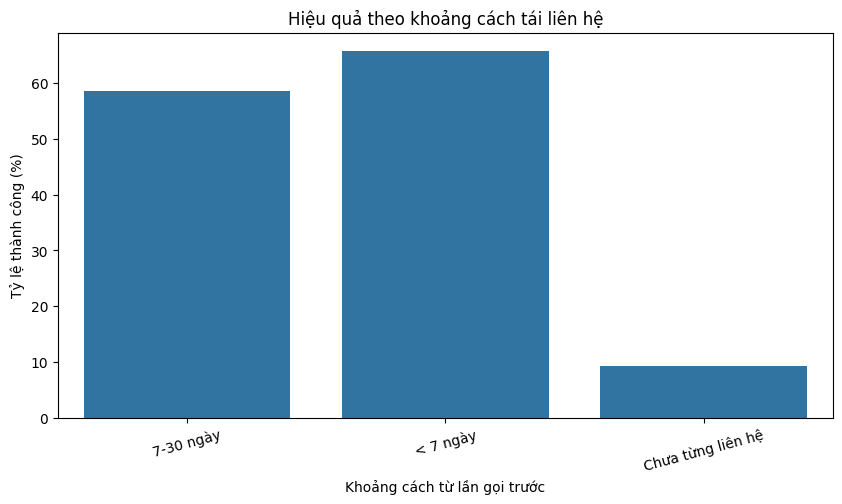

         pdays_group  total  success_rate
0          7-30 ngày    398     58.542714
1           < 7 ngày   1117     65.711728
2  Chưa từng liên hệ  39673      9.258186


In [10]:
# Xử lý pdays: 999 = chưa từng liên hệ
df['pdays_group'] = df['pdays'].apply(lambda x: 
    'Chưa từng liên hệ' if x == 999 else
    '< 7 ngày' if x < 7 else
    '7-30 ngày' if x < 30 else
    '> 30 ngày'
)

pdays_analysis = df.groupby('pdays_group')['y'].agg([
    ('total', 'count'),
    ('success_rate', lambda x: (x == 'yes').mean() * 100)
]).reset_index()

# Visualize
plt.figure(figsize=(10, 5))
sns.barplot(data=pdays_analysis, x='pdays_group', y='success_rate')
plt.xlabel('Khoảng cách từ lần gọi trước')
plt.ylabel('Tỷ lệ thành công (%)')
plt.title('Hiệu quả theo khoảng cách tái liên hệ')
plt.xticks(rotation=15)
plt.show()

print(pdays_analysis)

**Kết quả phân tích:**
- Hai nhóm đã từng liên hệ trước đó có **tỷ lệ thành công cao vượt trội** (gấp 6–7 lần so với nhóm chưa từng liên hệ).  
- Đặc biệt, **liên hệ lại trong vòng 1 tuần** đạt tỷ lệ thành công cao nhất (~65%).  
- Ngược lại, nhóm khách hàng “chưa từng liên hệ” chiếm phần lớn dữ liệu nhưng có tỷ lệ thành công rất thấp.

**Kết luận:**
- **Khoảng cách tái liên hệ ngắn giúp tăng khả năng thành công rõ rệt.**  
- Các khách hàng từng được liên hệ gần đây (dưới 7 ngày) thể hiện **hành vi tích cực và sẵn sàng cao hơn**.  
- Dữ liệu này củng cố giả thuyết rằng **“sự quen thuộc và ghi nhớ thương hiệu”** đóng vai trò quan trọng trong chiến dịch gọi điện marketing.

**Gợi ý ứng dụng:**
- Ưu tiên gọi lại cho khách hàng **đã từng tương tác trong vòng 1–4 tuần gần nhất**.  
- Có thể thiết lập quy tắc scoring để nhóm “<7 ngày” và “7–30 ngày” được xếp hạng ưu tiên cao trong mô hình dự đoán.

### Bước 3: Phân tích biến previous (Số lần gọi trong chiến dịch trước)

**Mục tiêu:**  
Xem xét mối quan hệ giữa **số lần khách hàng được gọi trong các chiến dịch trước** và **khả năng đồng ý ở chiến dịch hiện tại**.

In [11]:
# Nhóm previous
df['previous_group'] = df['previous'].apply(lambda x:
    '0 lần' if x == 0 else
    '1-2 lần' if x <= 2 else
    '3-5 lần' if x <= 5 else
    '> 5 lần'
)

previous_analysis = df.groupby('previous_group')['y'].agg([
    ('total', 'count'),
    ('success_rate', lambda x: (x == 'yes').mean() * 100)
]).reset_index()

print(previous_analysis)

  previous_group  total  success_rate
0          0 lần  35563      8.832213
1        1-2 lần   5625     26.648889


**Kết quả thống kê:**
- Phần lớn khách hàng **chưa từng được liên hệ** (≈ 86%), và nhóm này có tỷ lệ thành công rất thấp (~9%).  
- Nhóm **đã được gọi 1–2 lần trước đây** có tỷ lệ thành công cao gấp **3 lần** so với nhóm chưa từng liên hệ.

**Kết luận:**
- **Lịch sử liên hệ tích cực** có ảnh hưởng rõ rệt đến khả năng phản hồi.  
- Việc khách hàng đã được tiếp cận trước giúp họ **ghi nhớ thương hiệu và giảm sự e dè**, từ đó tăng tỷ lệ chấp nhận lời mời gửi tiết kiệm.

**Gợi ý ứng dụng:**
- Ưu tiên tái liên hệ với khách hàng **đã từng được gọi 1–2 lần trước đây**, đặc biệt là những người đã có phản hồi tốt (liên hệ với `poutcome = success`).  
- Trong mô hình dự đoán, biến `previous` nên được coi là một trong những **feature trọng yếu** để xác định nhóm khách hàng tiềm năng.

### Bước 4: Phân tích biến poutcome (Kết quả chiến dịch trước)

**Mục tiêu:**  
Phân tích ảnh hưởng của **kết quả chiến dịch trước (`poutcome`)** đến khả năng khách hàng đồng ý trong chiến dịch hiện tại.

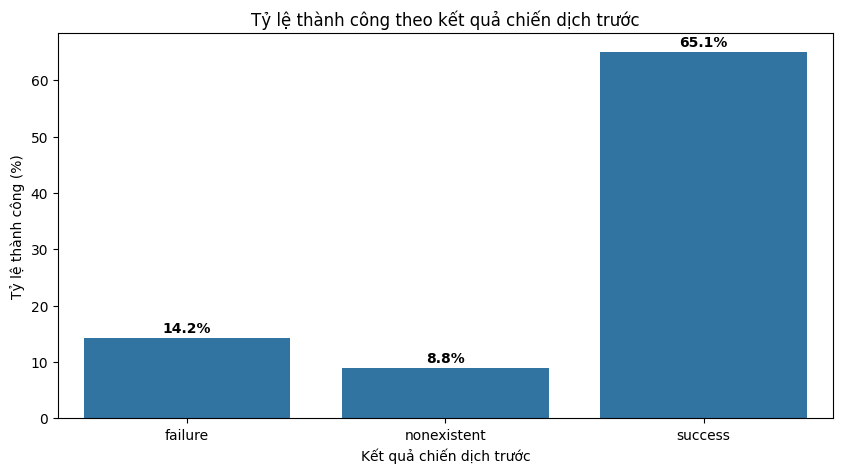

INSIGHT QUAN TRỌNG NHẤT:
      poutcome  total  yes_count  success_rate
0      failure   4252        605     14.228598
1  nonexistent  35563       3141      8.832213
2      success   1373        894     65.112891


In [12]:
# KEY INSIGHT: poutcome = success → tỷ lệ "yes" cao vượt trội
poutcome_analysis = df.groupby('poutcome')['y'].agg([
    ('total', 'count'),
    ('yes_count', lambda x: (x == 'yes').sum()),
    ('success_rate', lambda x: (x == 'yes').mean() * 100)
]).reset_index()

# Visualize
plt.figure(figsize=(10, 5))
sns.barplot(data=poutcome_analysis, x='poutcome', y='success_rate')
plt.xlabel('Kết quả chiến dịch trước')
plt.ylabel('Tỷ lệ thành công (%)')
plt.title('Tỷ lệ thành công theo kết quả chiến dịch trước')
for i, v in enumerate(poutcome_analysis['success_rate']):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
plt.show()

print("INSIGHT QUAN TRỌNG NHẤT:")
print(poutcome_analysis)


**Kết quả thống kê:**
- Nhóm **`success`** có tỷ lệ đồng ý cực cao (≈65%), vượt xa so với mức trung bình toàn bộ dataset (~11%).  
- Nhóm **`failure`** vẫn có tỷ lệ đồng ý khá hơn nhóm chưa từng liên hệ (`nonexistent`), cho thấy khách hàng từng được gọi thường có **độ nhận biết và tương tác cao hơn**.

**Kết luận:**
- **Kết quả chiến dịch trước là yếu tố dự báo mạnh mẽ nhất cho khả năng thành công hiện tại.**  
- Khách hàng đã từng “thành công” trong chiến dịch cũ là nhóm **lead chất lượng cao**, nên được ưu tiên trong chiến dịch mới.  
- Mặc dù nhóm `nonexistent` chiếm tỷ trọng lớn, nhưng hiệu quả thấp, cần các chiến lược tiếp cận khác biệt (ví dụ: quảng cáo nhận diện, email đầu phễu, ưu đãi mới...).

**Gợi ý ứng dụng:**
- Có thể tạo thêm feature nhị phân: `poutcome_success = 1 nếu success else 0` để mô hình học tốt hơn.  
- Sử dụng `poutcome` làm **feature trọng tâm** trong mô hình Random Forest hoặc GBT để đo mức độ ảnh hưởng đến dự đoán `y`.


### Bước 5: Phân tích kết hợp (campaign × poutcome)

**Mục tiêu:**  
Phân tích mối tương quan giữa **số lần gọi trong chiến dịch hiện tại (`campaign`)** và **kết quả của chiến dịch trước (`poutcome`)** để xem liệu tần suất gọi có tác động khác nhau theo từng nhóm khách hàng.

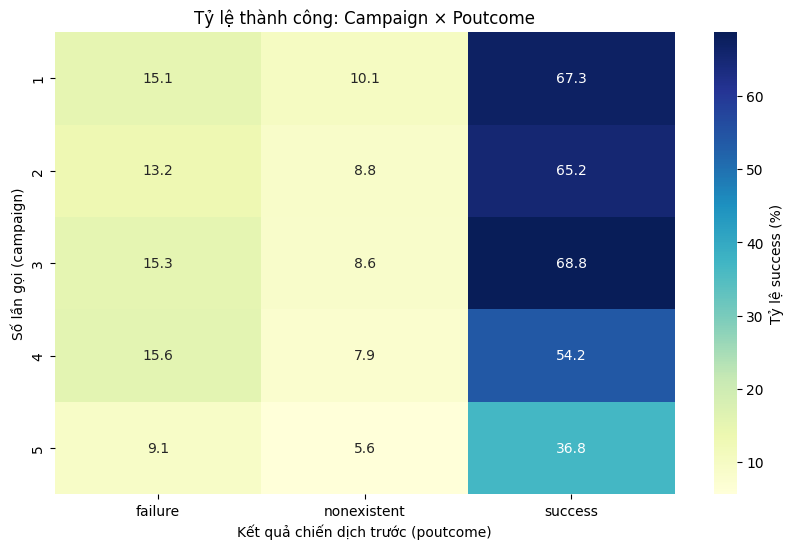

In [13]:
# Heatmap: Tần suất gọi vs Kết quả trước
cross_analysis = pd.crosstab(
    df['campaign'].apply(lambda x: min(x, 5)),  # Nhóm >5 thành 5
    df['poutcome'],
    df['y'].apply(lambda x: 1 if x=='yes' else 0),
    aggfunc='mean'
) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(cross_analysis, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': 'Tỷ lệ success (%)'})
plt.xlabel('Kết quả chiến dịch trước (poutcome)')
plt.ylabel('Số lần gọi (campaign)')
plt.title('Tỷ lệ thành công: Campaign × Poutcome')
plt.show()

**Kết quả heatmap:**
- Với **nhóm khách hàng từng thành công (`poutcome = success`)**, tỷ lệ đồng ý hiện tại duy trì ở mức **rất cao (≈65–69%)** ngay cả khi số lần gọi tăng.  
  → Cho thấy đây là nhóm “khách hàng trung thành” hoặc đã có thiện cảm với ngân hàng.  
- Với **nhóm `failure`**, tỷ lệ thành công dao động quanh **13–15%**, không tăng nhiều khi gọi lại.  
- **Nhóm `nonexistent`** (chưa từng liên hệ) có tỷ lệ thấp nhất (**~8–10%**) và giảm dần khi số lần gọi tăng.  

**Kết luận:**
- **Hiệu quả gọi lại phụ thuộc mạnh vào kết quả chiến dịch trước.**  
- Gọi nhiều lần không cải thiện kết quả nếu khách hàng **chưa từng liên hệ** hoặc **đã từ chối**.  
- Tuy nhiên, **nhóm đã từng “success”** có khả năng tái phản hồi tốt ngay cả khi số lần gọi cao hơn.

**Gợi ý ứng dụng:**
- Khi triển khai chiến dịch mới:
  - Ưu tiên nhóm **poutcome = success**, vì có ROI cao nhất.  
  - Giới hạn số lần gọi với nhóm **nonexistent** để tránh lãng phí nguồn lực.  
  - Có thể áp dụng **chiến lược khác biệt theo phân khúc** (ví dụ: gọi lại 1–2 lần cho nhóm “failure”, nhưng không vượt 3 lần cho nhóm mới).


## PHẦN 2: Feature Engineering & Modeling

### Bước 6: Chuẩn bị dữ liệu cho PySpark

**Mục tiêu:**  
Chuyển đổi và định dạng dữ liệu đã tiền xử lý sang cấu trúc phù hợp với **PySpark MLlib**, phục vụ huấn luyện mô hình trên tập dữ liệu lớn.

In [14]:
# Khởi tạo Spark
spark = SparkSession.builder \
    .appName("FrequencyCallbackAnalysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Chuyển sang Spark DataFrame
df_spark = spark.createDataFrame(df)

# Tạo feature mới
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Encode categorical
indexer_poutcome = StringIndexer(inputCol="poutcome", outputCol="poutcome_idx")
df_spark = indexer_poutcome.fit(df_spark).transform(df_spark)

# Tạo feature: có từng liên hệ trước không
df_spark = df_spark.withColumn('has_previous_contact', 
                               F.when(F.col('pdays') != 999, 1).otherwise(0))

# Encode target
indexer_y = StringIndexer(inputCol="y", outputCol="label")
df_spark = indexer_y.fit(df_spark).transform(df_spark)

### Bước 7: Train Random Forest với PySpark

**Mục tiêu:**  
Xây dựng mô hình **Random Forest Classifier** để dự đoán khả năng khách hàng đồng ý tham gia gửi tiết kiệm (`y = yes`), dựa trên các biến hành vi liên hệ và kết quả chiến dịch trước.

In [15]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Feature assembly
feature_cols = ['campaign', 'pdays', 'previous', 'poutcome_idx', 'has_previous_contact']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_spark = assembler.transform(df_spark)

# Split data
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

# Train Random Forest
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='label',
    numTrees=100,
    maxDepth=10,
    seed=42
)

model = rf.fit(train_data)

# Predict
predictions = model.transform(test_data)

# Evaluate
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

auc = evaluator_auc.evaluate(predictions)
accuracy = evaluator_acc.evaluate(predictions)

print(f" Random Forest Results:")
print(f"  - AUC: {auc:.4f}")
print(f"  - Accuracy: {accuracy:.4f}")

# Feature importance
feature_importance = model.featureImportances
for i, col in enumerate(feature_cols):
    print(f"  - {col}: {feature_importance[i]:.4f}")

 Random Forest Results:
  - AUC: 0.6292
  - Accuracy: 0.9004
  - campaign: 0.0291
  - pdays: 0.5598
  - previous: 0.0347
  - poutcome_idx: 0.0134
  - has_previous_contact: 0.3630


#### Nhận xét kết quả mô hình Random Forest

**Kết quả đánh giá hiệu năng:**
- **AUC:** 0.6292  
- **Accuracy:** 0.9004  

**🔹 Nhận xét tổng quan:**
- **Accuracy cao (≈90%)** nhưng **AUC chỉ 0.63**, cho thấy mô hình **thiên lệch về lớp “No” (majority class)**.  
- Do dữ liệu mất cân bằng (chỉ ~11% “Yes”), nên độ chính xác cao chưa phản ánh tốt năng lực phân biệt nhóm khách hàng tiềm năng.  
- AUC ~0.63 vẫn thể hiện mô hình có **khả năng phân biệt ở mức trung bình**, cần cải thiện thêm bằng tuning hoặc cân bằng lớp.

**Feature Importance:**
| Biến | Độ quan trọng | Giải thích |
|------|----------------|------------|
| `pdays` | **0.5598** | Biến mạnh nhất — thể hiện thời gian kể từ lần liên hệ trước, có ảnh hưởng trực tiếp đến hành vi phản hồi. |
| `has_previous_contact` | **0.3630** | Cho thấy việc từng được liên hệ trước đó là yếu tố quan trọng thứ hai. |
| `previous` | 0.0347 | Mức độ liên hệ trước đây có ảnh hưởng nhẹ đến xác suất đồng ý. |
| `campaign` | 0.0291 | Tần suất gọi trong chiến dịch hiện tại có vai trò bổ trợ. |
| `poutcome_idx` | 0.0134 | Dù có ý nghĩa trong EDA, nhưng khi kết hợp với `pdays` và `has_previous_contact` thì bị giảm trọng số do trùng thông tin. |

**Kết luận:**
- Mô hình Random Forest **xác nhận lại kết quả EDA**:  
  Khách hàng từng được liên hệ gần đây (`pdays` thấp) và có lịch sử tương tác (`has_previous_contact = 1`) là nhóm có xác suất đồng ý cao nhất.  
- Tuy nhiên, cần cải thiện khả năng phân biệt (`AUC`) bằng:
  - Tuning hyperparameter (`numTrees`, `maxDepth`, `minInstancesPerNode`).  
  - Áp dụng **SMOTE / class weight** để xử lý mất cân bằng lớp.  
  - Kết hợp với mô hình **GBT** để tăng khả năng học phi tuyến.

**Tóm tắt trình bày:**
> “Random Forest đạt Accuracy 90% nhưng AUC 0.63, cho thấy mô hình đang dự đoán tốt lớp ‘No’ nhưng chưa đủ mạnh cho lớp ‘Yes’.  
> Các biến `pdays` và `has_previous_contact` giữ vai trò chủ đạo — khẳng định tầm quan trọng của hành vi tái liên hệ khách hàng.”
